<a href="https://colab.research.google.com/github/arthurflor23/handwritten-text-recognition/blob/master/src/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/arthurflor23/handwritten-text-recognition/blob/master/doc/image/header.png?raw=true" />

# Handwritten Text Recognition using TensorFlow 2.x

This tutorial shows how you can use the project [Handwritten Text Recognition](https://github.com/arthurflor23/handwritten-text-recognition) in your Google Colab.



## 1 Localhost Environment

We'll make sure you have the project in your Google Drive with the datasets in HDF5. If you already have structured files in the cloud, skip this step.

### 1.1 Datasets

The datasets that you can use:

a. [Bentham](http://www.transcriptorium.eu/~tsdata/)

b. [IAM](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database)

c. [Rimes](http://www.a2ialab.com/doku.php?id=rimes_database:start)

d. [Saint Gall](https://fki.tic.heia-fr.ch/databases/saint-gall-database)

e. [Washington](https://fki.tic.heia-fr.ch/databases/washington-database)

### 1.2 Raw folder

On localhost, download the code project from GitHub and extract the chosen dataset (or all if you prefer) in the **raw** folder. Don't change anything of the structure of the dataset, since the scripts were made from the **original structure** of them. Your project directory will be like this:

```
.
├── raw
│   ├── bentham
│   │   ├── BenthamDatasetR0-GT
│   │   └── BenthamDatasetR0-Images
│   ├── iam
│   │   ├── ascii
│   │   ├── forms
│   │   ├── largeWriterIndependentTextLineRecognitionTask
│   │   ├── lines
│   │   └── xml
│   ├── rimes
│   │   ├── eval_2011
│   │   ├── eval_2011_annotated.xml
│   │   ├── training_2011
│   │   └── training_2011.xml
│   ├── saintgall
│   │   ├── data
│   │   ├── ground_truth
│   │   ├── README.txt
│   │   └── sets
│   └── washington
│       ├── data
│       ├── ground_truth
│       ├── README.txt
│       └── sets
└── src
    ├── data
    │   ├── evaluation.py
    │   ├── generator.py
    │   ├── preproc.py
    │   ├── reader.py
    │   ├── similar_error_analysis.py
    ├── main.py
    ├── network
    │   ├── architecture.py
    │   ├── layers.py
    │   ├── model.py
    └── tutorial.ipynb

```

After that, create virtual environment and install the dependencies with python 3 and pip:

> ```python -m venv .venv && source .venv/bin/activate```

> ```pip install -r requirements.txt```

### 1.3 HDF5 files

Now, you'll run the *transform* function from **main.py**. For this, execute on **src** folder:

> ```python main.py --source=<DATASET_NAME> --transform```

Your data will be preprocess and encode, creating and saving in the **data** folder. Now your project directory will be like this:


```
.
├── data
│   ├── bentham.hdf5
│   ├── iam.hdf5
│   ├── rimes.hdf5
│   ├── saintgall.hdf5
│   └── washington.hdf5
├── raw
│   ├── bentham
│   │   ├── BenthamDatasetR0-GT
│   │   └── BenthamDatasetR0-Images
│   ├── iam
│   │   ├── ascii
│   │   ├── forms
│   │   ├── largeWriterIndependentTextLineRecognitionTask
│   │   ├── lines
│   │   └── xml
│   ├── rimes
│   │   ├── eval_2011
│   │   ├── eval_2011_annotated.xml
│   │   ├── training_2011
│   │   └── training_2011.xml
│   ├── saintgall
│   │   ├── data
│   │   ├── ground_truth
│   │   ├── README.txt
│   │   └── sets
│   └── washington
│       ├── data
│       ├── ground_truth
│       ├── README.txt
│       └── sets
└── src
    ├── data
    │   ├── evaluation.py
    │   ├── generator.py
    │   ├── preproc.py
    │   ├── reader.py
    │   ├── similar_error_analysis.py
    ├── main.py
    ├── network
    │   ├── architecture.py
    │   ├── layers.py
    │   ├── model.py
    └── tutorial.ipynb

```

Then upload the **data** and **src** folders in the same directory in your Google Drive.

## 2 Google Drive Environment


### 2.1 TensorFlow 2.x

Make sure the jupyter notebook is using GPU mode.

In [1]:
!nvidia-smi

Thu Oct  7 06:19:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


### 2.2 Google Drive

Mount your Google Drive partition.

**Note:** *\"Colab Notebooks/handwritten-text-recognition/src/\"* was the directory where you put the project folders, specifically the **src** folder.

In [3]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)

%cd "./gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src/"
!ls -l

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src
total 220
drwx------ 2 root root   4096 Sep 27 12:47 data
-rw------- 1 root root   9074 Sep 27 12:47 main.py
drwx------ 2 root root   4096 Sep 27 12:47 network
-rw------- 1 root root 207372 Oct  7 06:19 tutorial.ipynb


After mount, you can see the list os files in the project folder.

## 3 Set Python Classes

### 3.1 Environment

First, let's define our environment variables.

Set the main configuration parameters, like input size, batch size, number of epochs and list of characters. This make compatible with **main.py** and jupyter notebook:

* **dataset**: "bentham", "iam", "rimes", "saintgall", "washington"

* **arch**: network to run: "bluche", "puigcerver", "flor"

* **epochs**: number of epochs

* **batch_size**: number size of the batch

In [4]:
import os
import datetime
import string

# define parameters
source = "doctors"
arch = "cnn_bilstm"
epochs = 200
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch, "final split - simpler + dropout=0.1 + 4layers + Adam")
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/doctors.hdf5
output ../output/doctors/cnn_bilstm/final split - simpler + dropout=0.1 + 4layers + Adam
target ../output/doctors/cnn_bilstm/final split - simpler + dropout=0.1 + 4layers + Adam/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


### 3.2 DataGenerator Class

The second class is **DataGenerator()**, responsible for:

* Load the dataset partitions (train, valid, test);

* Manager batchs for train/validation/test process.

In [5]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 1767
Validation images: 295
Test images: 884


### 3.3 HTRModel Class

The third class is **HTRModel()**, was developed to be easy to use and to abstract the complicated flow of a HTR system. It's responsible for:

* Create model with Handwritten Text Recognition flow, in which calculate the loss function by CTC and decode output to calculate the HTR metrics (CER, WER and SER);

* Save and load model;

* Load weights in the models (train/infer);

* Make Train/Predict process using *generator*.

To make a dynamic HTRModel, its parameters are the *architecture*, *input_size* and *vocab_size*.

In [6]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15)

model.compile(learning_rate=0.001, initial_step=0, target="model.jpg", output=output_path,)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 128, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 128, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 128, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 128, 16)     64        
_________________________________________________________________
dropout (Dropout)            (None, 1024, 128, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 64, 16)       0     

## 4 Training

The training process is similar to the *fit()* of the Keras. After training, the information (epochs and minimum loss) is save.

In [7]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/200
111/111 [==============================] - 82s 392ms/step - loss: 133.3140 - val_loss: 627.0851

Epoch 00001: val_loss improved from inf to 627.08514, saving model to ../output/doctors/cnn_bilstm/final split - simpler + dropout=0.1 + 4layers + Adam/checkpoint_weights.hdf5
Epoch 2/200
111/111 [==============================] - 41s 368ms/step - loss: 106.1905 - val_loss: 590.2855

Epoch 00002: val_loss improved from 627.08514 to 590.28546, saving model to ../output/doctors/cnn_bilstm/final split - simpler + dropout=0.1 + 4layers + Adam/checkpoint_weights.hdf5
Epoch 3/200
111/111 [==============================] - 41s 368ms/step - loss: 95.9149 - val_loss: 528.2646

Epoch 00003: val_loss improved from 590.28546 to 528.26465, saving model to ../output/doctors/cnn_bilstm/final split - simpler + dropout=0.1 + 4layers + Adam/checkpoint_weights.hdf5
Epoch 4/200
111/111 [==============================] - 41s 368ms/step - loss: 90.2580 - val_loss: 368.9075

Epoch 00004: val_loss impr

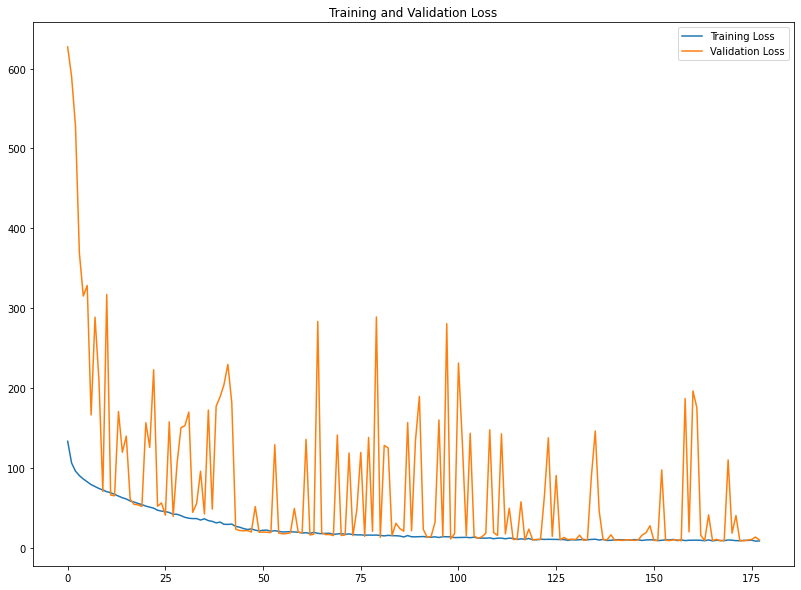

In [9]:
from matplotlib import pyplot as plt
# acc = h.history['accuracy']
# val_acc = h.history['val_accuracy']
import pandas as pd
log_data = open(os.path.join(output_path, "epochs.log")).read().splitlines()
loss =[]
val_loss=[]
for line in log_data:
  split = line.split(";")
  if split[1].find("loss") == -1:
    loss.append(float(split[1]))
  if split[2].find("val_loss") == -1:
    val_loss.append(float(split[2]))

epochs_range = range(178)

plt.figure(figsize=(30, 10))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5 Predict

The predict process is similar to the *predict* of the Keras:

Model Predict
56/56 [==============================] - 8s 107ms/step
CTC Decode
 1/56 [..............................] - ETA: 1:34

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


56/56 [==============================] - 94s 2s/step



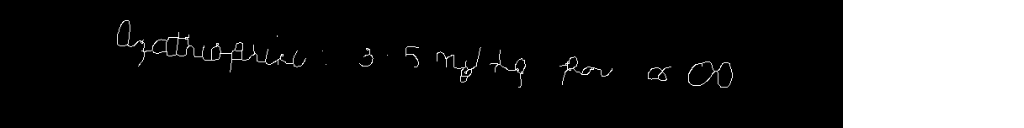

Azathioprine: 3-5 mg/kg Per os OD
Azathoirine: 3-5 mg/kg Per os OD 




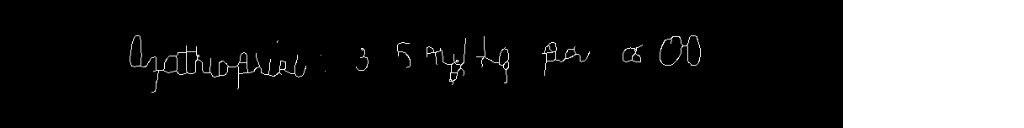

Azathioprine: 3-5 mg/kg Per os OD
Azathoirine: 3-5 mg/kg Per os OD 




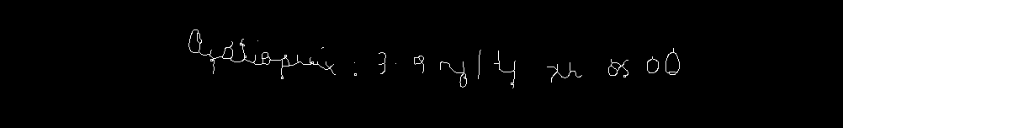

Azathioprine: 3-5 mg/kg Per os OD
Azathoirine: 3-5 mg/kg Per os OD 




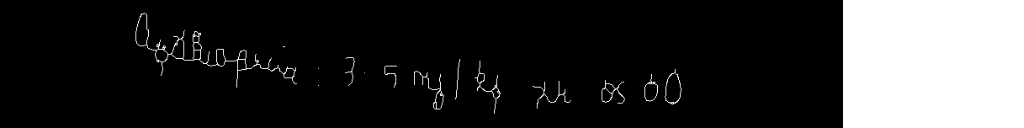

Azathioprine: 3-5 mg/kg Per os OD
Azathoirine: 3-5 mg/kg Per os OD 




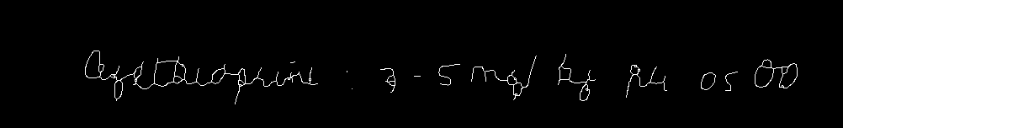

Azathioprine: 3-5 mg/kg Per os OD
Azathoirine: 3-5 mg/kg Per os OD 




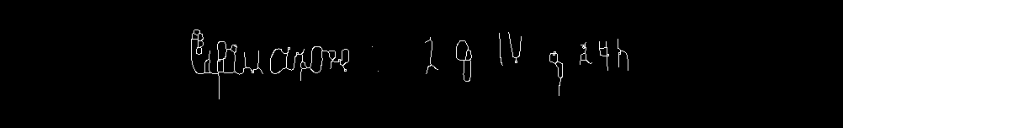

Ceftriaxone: 2 g IV q24h
Ceftriaxone: 2 g IV q24h 




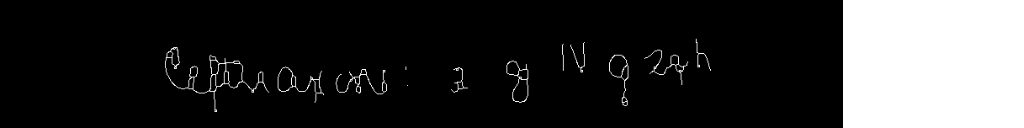

Ceftriaxone: 2 g IV q24h
Ceftriaxone: 2 g IV q24h 




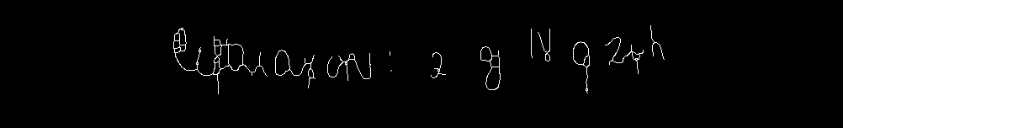

Ceftriaxone: 2 g IV q24h
Ceftriaxone: 2 g IV q24h 




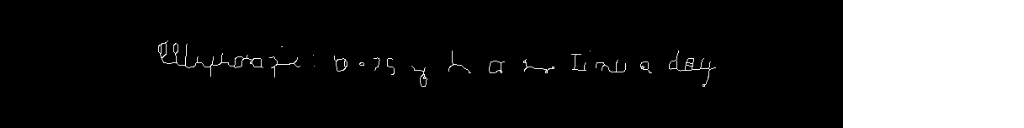

Chlorpromazine: 10-25 mg Per os three times a day
Chlorpopmazine: 10-25 mg Per os three times a day 




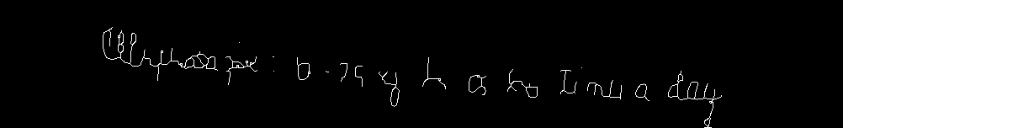

Chlorpromazine: 10-25 mg Per os three times a day
Chlorpopmazin: 15 mg Per os three times a day 



In [10]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

## 6 Evaluate

Evaluation process is more manual process. Here we have the `ocr_metrics`, but feel free to implement other metrics instead. In the function, we have three parameters: 

* predicts
* ground_truth
* norm_accentuation (calculation with/without accentuation)
* norm_punctuation (calculation with/without punctuation marks)

In [11]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate:       {evaluate[0]:.8f}",
    f"Word Error Rate:            {evaluate[1]:.8f}",
    f"Sequence Error Rate:        {evaluate[2]:.8f}",
    # f"Accuracy:             {evaluate[3]:.8f}",
    f"Precision Score (macro):    {evaluate[3]:.8f}",
    f"Precision Score (micro):    {evaluate[4]:.8f}",
    f"Precision Score (weighted): {evaluate[5]:.8f}",
    f"Recall Score (macro):       {evaluate[6]:.8f}",
    f"Recall Score (micro):       {evaluate[7]:.8f}",
    f"Recall Score (weighted):    {evaluate[8]:.8f}",
    f"F1 Score (macro):           {evaluate[9]:.8f}",
    f"F1 Score (micro):           {evaluate[10]:.8f}",
    f"F1 Score (weighted):        {evaluate[11]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    884
Total time:           0:01:41.753459
Time per item:        0:00:00.115106

Metrics:
Character Error Rate:       0.06432944
Word Error Rate:            0.14498651
Sequence Error Rate:        0.50452489
Precision Score (macro):    0.03443780
Precision Score (micro):    0.49547511
Precision Score (weighted): 0.91038517
Recall Score (macro):       0.01901326
Recall Score (micro):       0.49547511
Recall Score (weighted):    0.49547511
F1 Score (macro):           0.02321178
F1 Score (micro):           0.49547511
F1 Score (weighted):        0.60584465


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
